# Shakhnazar Kapar
Final project - "Skin cancer detection"

In [1]:
import os
import numpy as np
import tensorflow as tf
import shutil
import pandas as pd
import seaborn as sb
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import load_model
from google.colab import files



# Connecting to google drive(We used Almas's google drive).
We uploaded dataset to google drive for convenience.
Actual dataset link where we get dataset is  = `https://universe.roboflow.com/redronin/preprocessing-and-augmentations-zl5il/model/11`


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the paths to the training, validation, and testing directories


In [3]:
train_dir = '/content/drive/MyDrive/skin cancer dataset/train'
valid_dir = '/content/drive/MyDrive/skin cancer dataset/valid'
test_dir = '/content/drive/MyDrive/skin cancer dataset/test'

In [4]:
# Get the class names
class_names = os.listdir(train_dir)

# print list class names
print("Classes in the dataset:")
print(class_names)

Classes in the dataset:
['malignant', 'benign']


In [5]:
# show paths images in the train class
imagepaths = list(glob(train_dir + "/**/*.*"))
print(imagepaths)

['/content/drive/MyDrive/skin cancer dataset/train/malignant/1028_jpg.rf.86fc1ae5b047dc72894254be54b4b97a.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1019_jpg.rf.843014adaa28610d6bfdf33d73d3af10.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1017_jpg.rf.4866f288b0c5ee64f3e66013bf44b81c.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1002_jpg.rf.1c390169f9457035dc6ff47b8c47c723.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1015_jpg.rf.708bf0e2ec6b26e97ce3c7edbe7213ed.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1011_jpg.rf.a59ed1c7e35f6fd1d83165ee9a3e8b64.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1001_jpg.rf.3a1e65f79bdf41fe76cde5373c72002a.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1026_jpg.rf.3492c06625ad24449870e9f425bac6f4.jpg', '/content/drive/MyDrive/skin cancer dataset/train/malignant/1001_jpg.rf.940316f89e749b645a1f86f8ff92dec4.jpg', 

# What contain our dataset?

In [6]:
# Initialize a dictionary to store the image counts for each class
class_image_counts = {}

for class_label in class_names:
    class_dir_train = os.path.join(train_dir, class_label)
    class_dir_valid = os.path.join(valid_dir, class_label)
    class_dir_test = os.path.join(test_dir, class_label)

    num_images_train = len(os.listdir(class_dir_train))
    num_images_valid = len(os.listdir(class_dir_valid))
    num_images_test = len(os.listdir(class_dir_test))

    total_images = num_images_train + num_images_valid + num_images_test

    class_image_counts[class_label] = total_images
for class_label, count in class_image_counts.items():
    print(f"Class: {class_label}, have images: {count}")

# Calculate the overall number of images in the dataset
overall_images = sum(class_image_counts.values())
print("Overall images in the dataset:", overall_images)

Class: malignant, have images: 1345
Class: benign, have images: 1348
Overall images in the dataset: 2693


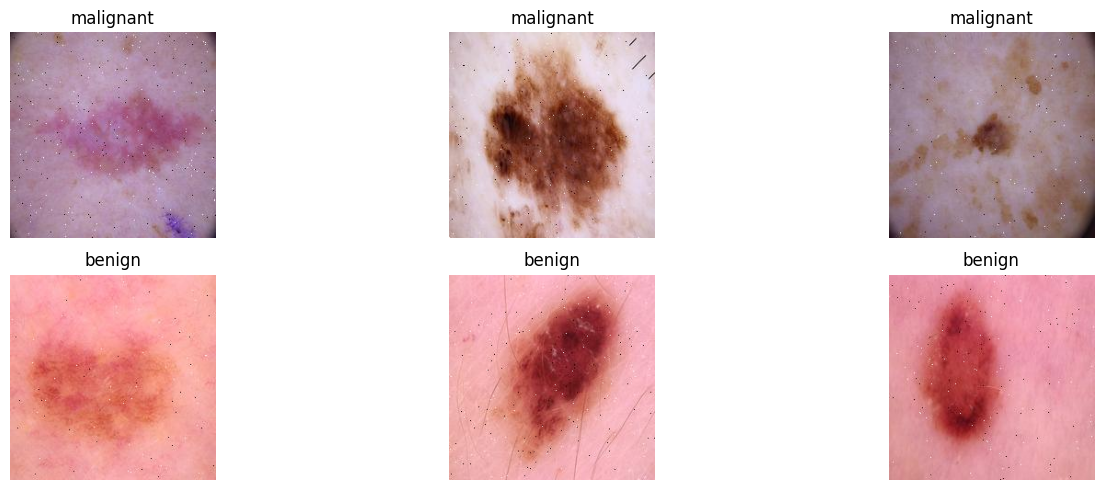

In [7]:

def show_sample_images(data_dir, class_names, num_samples=3):
    plt.figure(figsize=(15, 5))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_dir)

        sample_images = random.sample(image_files, min(num_samples, len(image_files)))

        for j, image_file in enumerate(sample_images):
            image_path = os.path.join(class_dir, image_file)
            img = Image.open(image_path)

            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display sample images
show_sample_images(train_dir, class_names)


In [8]:
# Create a DataFrame to store image paths and labels
def create_dataframe(data_dir):
    image_paths = []
    labels = []
    class_names = os.listdir(data_dir)

    for class_label in class_names:
        class_dir = os.path.join(data_dir, class_label)
        image_files = os.listdir(class_dir)
        image_paths.extend([os.path.join(class_dir, img) for img in image_files])
        labels.extend([class_label] * len(image_files))

    return pd.DataFrame({'ImagePath': image_paths, 'Label': labels})

# Create DataFrames for each dataset
train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)


print(train_df.head())
print("\n")
print(train_df.tail())

print("\n\n\n")

print(valid_df.head())
print("\n")
print(valid_df.tail())

print("\n\n\n")

print(test_df.head())
print("\n")
print(test_df.tail())


                                           ImagePath      Label
0  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
1  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
2  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
3  /content/drive/MyDrive/skin cancer dataset/tra...  malignant
4  /content/drive/MyDrive/skin cancer dataset/tra...  malignant


                                              ImagePath   Label
1795  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1796  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1797  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1798  /content/drive/MyDrive/skin cancer dataset/tra...  benign
1799  /content/drive/MyDrive/skin cancer dataset/tra...  benign




                                           ImagePath   Label
0  /content/drive/MyDrive/skin cancer dataset/val...  benign
1  /content/drive/MyDrive/skin cancer dataset/val...  benign
2  /content/drive/MyDrive/skin cancer datas

<Figure size 800x600 with 0 Axes>

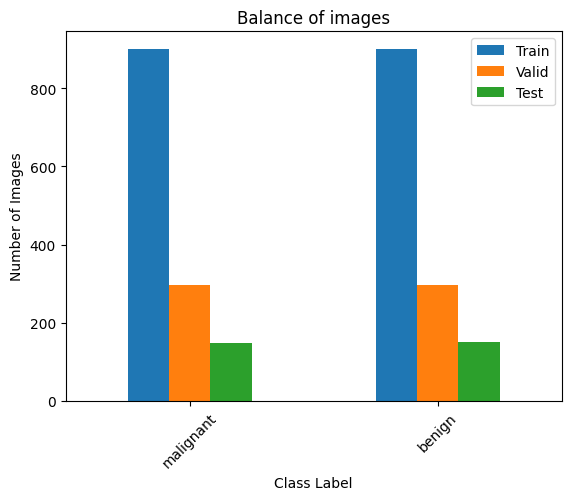

Train Dataset:
malignant    900
benign       900
Name: Label, dtype: int64

Validation Dataset:
benign       298
malignant    297
Name: Label, dtype: int64

Test Dataset:
benign       150
malignant    148
Name: Label, dtype: int64


In [9]:
# Get the counts for each class in each dataset
train_counts = train_df['Label'].value_counts()
valid_counts = valid_df['Label'].value_counts()
test_counts = test_df['Label'].value_counts()

class_counts = pd.concat([train_counts, valid_counts, test_counts], axis=1, keys=['Train', 'Valid', 'Test'])

# Plot the balance of images
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Balance of images')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

print("Train Dataset:")
print(train_counts)
print("\nValidation Dataset:")
print(valid_counts)
print("\nTest Dataset:")
print(test_counts)


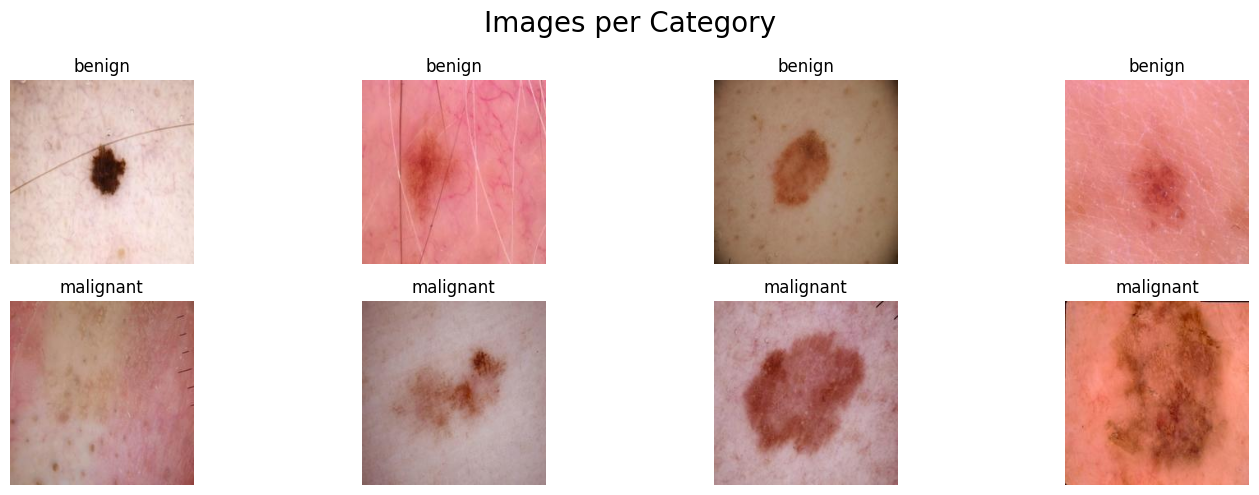

In [10]:
def show_images_per_category(df, num_images=4, figsize=(15, 5)):
    categories = df['Label'].unique()
    num_categories = len(categories)

    fig, ax = plt.subplots(num_categories, num_images, figsize=figsize)
    fig.suptitle('Images per Category', fontsize=20)

    for i, cat in enumerate(categories):
        indices = df[df['Label'] == cat].index
        num_indices = len(indices)

        random_indices = random.sample(indices.tolist(), min(num_images, num_indices)) if num_indices > 0 else [None] * num_images

        for j, idx in enumerate(random_indices):
            if idx is not None:
                img_path = df.loc[idx, 'ImagePath']
                img = np.array(Image.open(img_path))
                ax[i, j].imshow(img)
                ax[i, j].set_title(f'{cat}')
            else:
                ax[i, j].axis('off')
                ax[i, j].text(0.5, 0.5, f"No images found for {cat}", horizontalalignment='center', verticalalignment='center', fontsize=12)

            ax[i, j].axis('off')

    plt.tight_layout()
    plt.show()

show_images_per_category(test_df)


# Main part goes here!
Data preprocessing and augmentation


In [11]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64

# Data augmentation training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Create data generators


In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 1800 images belonging to 2 classes.
Found 595 images belonging to 2 classes.
Found 298 images belonging to 2 classes.


# Build the model


In [14]:
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
m = tf.keras.Sequential([
    hub.KerasLayer(module_url, output_shape=[2048], trainable=False),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

m.build([None, IMG_HEIGHT, IMG_WIDTH, 3])

m.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 21804833 (83.18 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


# Fitting, Evaluating, Plotting the model

Epoch 1/5
29/29 [==============================] - 1084s 37s/step - loss: 0.6569 - accuracy: 0.6278 - val_loss: 0.6423 - val_accuracy: 0.6538
Epoch 2/5
29/29 [==============================] - 35s 1s/step - loss: 0.5553 - accuracy: 0.7144 - val_loss: 0.6006 - val_accuracy: 0.6992
Epoch 3/5
29/29 [==============================] - 35s 1s/step - loss: 0.4998 - accuracy: 0.7661 - val_loss: 0.5790 - val_accuracy: 0.7076
Epoch 4/5
29/29 [==============================] - 35s 1s/step - loss: 0.4822 - accuracy: 0.7667 - val_loss: 0.5589 - val_accuracy: 0.7193
Epoch 5/5
298/298 [==============================] - 68s 224ms/step - loss: 0.5203 - accuracy: 0.7416
Test Loss: 0.5202669501304626
Test Accuracy: 0.7416107654571533


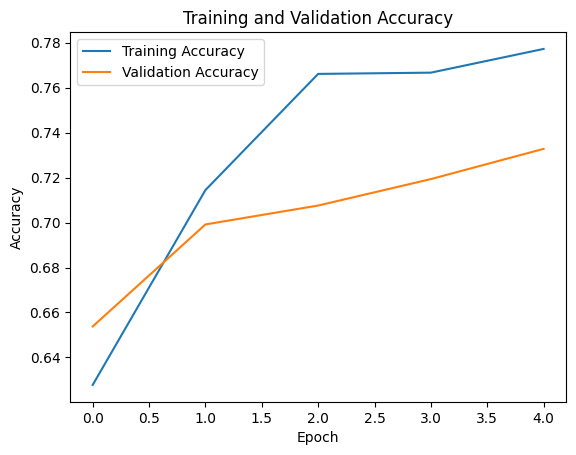

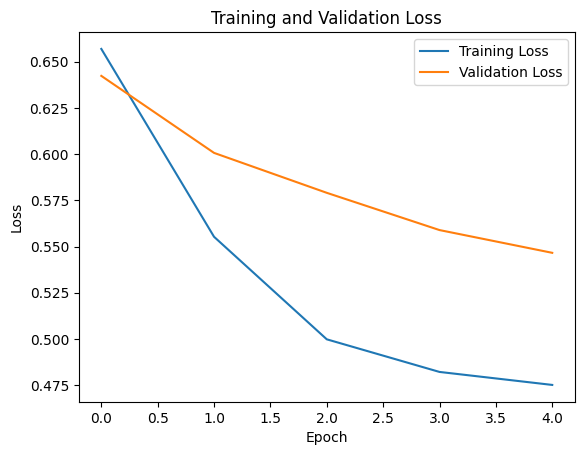

In [15]:
# Fit the model
history = m.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator
)

test_loss, test_accuracy = m.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# Visualize Images with Predictions:




Saving 748_jpg.rf.a54944c81cd81231c8c58258acba4465.jpg to 748_jpg.rf.a54944c81cd81231c8c58258acba4465.jpg
1/1 [==============================] - 0s 25ms/step


<ipython-input-43-b6ba34ad1d37>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_names[int(predictions[i] > 0.5)]
<ipython-input-43-b6ba34ad1d37>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(predictions[i]) if pred_label == 'malignant' else 1 - float(predictions[i])  # Convert to scalar value


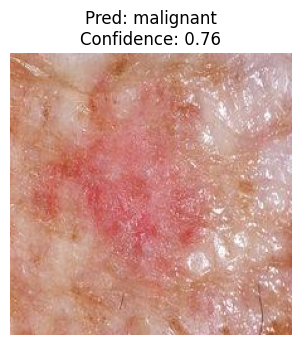

In [43]:
def visualize_uploaded_images(model, class_names, num_images=5):
    uploaded = files.upload()

    images = []
    for filename in uploaded.keys():
        img = Image.open(io.BytesIO(uploaded[filename]))
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        img = np.array(img) / 255.0
        images.append(img)

    images = np.array(images)

    # Make predictions
    predictions = model.predict(images)

    plt.figure(figsize=(15, 10))

    for i in range(len(images)):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        pred_label = class_names[int(predictions[i] > 0.5)]
        confidence = float(predictions[i]) if pred_label == 'malignant' else 1 - float(predictions[i])
        plt.title(f'Pred: {pred_label}\nConfidence: {confidence:.2f}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

class_names = ['benign', 'malignant']

# Visualize predictions on user-uploaded images
visualize_uploaded_images(m, class_names)


# Interesting numbers


298/298 [==============================] - 9s 29ms/step - loss: 0.5203 - accuracy: 0.7416
Test Loss: 0.5202669501304626
Test Accuracy: 0.7416107654571533
298/298 [==============================] - 4s 14ms/step

Additional Metrics:
Classification Report:
              precision    recall  f1-score   support

      benign       0.71      0.82      0.76       150
   malignant       0.78      0.66      0.72       148

    accuracy                           0.74       298
   macro avg       0.75      0.74      0.74       298
weighted avg       0.75      0.74      0.74       298



<ipython-input-48-9382408072c6>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(confidence_scores[i])  # Convert to scalar value
<ipython-input-48-9382408072c6>:27: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


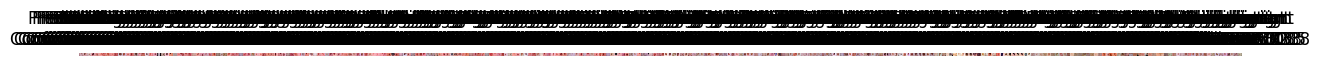

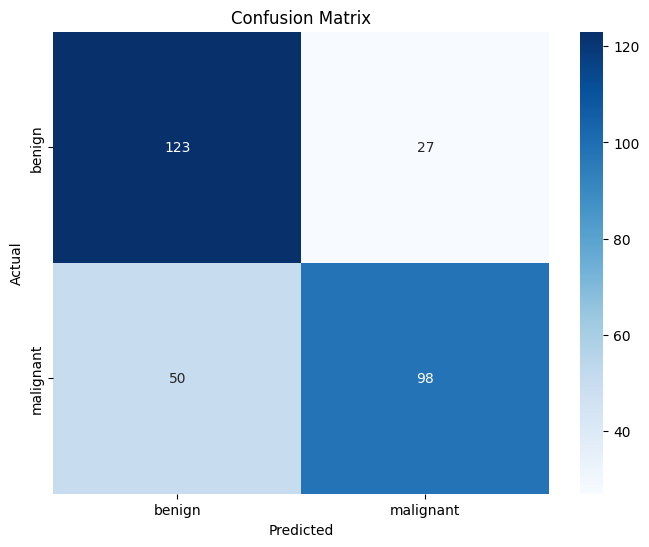

In [48]:
# Evaluate model on the test set
test_loss, test_accuracy = m.evaluate(test_generator, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict on test data
predictions = m.predict(test_generator)
predicted_classes = np.round(predictions).flatten()

print("\nAdditional Metrics:")
print("Classification Report:")
print(classification_report(test_generator.classes, predicted_classes, target_names=test_generator.class_indices.keys()))

confidence_scores = np.abs(predictions - 0.5)

plt.figure(figsize=(15, 10))
for i in range(len(predictions)):
    plt.subplot(1, len(predictions), i+1)
    plt.imshow(test_generator[i][0][0])
    pred_label = 'malignant' if predicted_classes[i] == 1 else 'benign'
    confidence = float(confidence_scores[i])
    plt.title(f'Pred: {pred_label}\nConfidence: {confidence:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_generator.classes, predicted_classes)
plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
